# Import Libraries


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, TensorDataset, DataLoader,SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision import transforms as tfs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
%matplotlib inline



# Making Filters

We define the scaling of a function as follows:
\begin{equation*}
f_j (u) = 2^{-2j} f(2^{-j} u)
\end{equation*}
So that
\begin{equation*}
\hat{f}_j (\omega) = \hat{f}(2^j \omega)
\end{equation*}
Our filter bank will have the following filters:
* One low pass filter, $\phi_J$
* $JQ$ direcitonal filters, $\psi_{j,q} (u) = 2^{-2j} \psi_q (2^{-j}u)$, where $0 \leq j < J$ are the scales and $0 \leq q < Q$ are the directions.

We define the following filters:
$$
L(r) = \begin{cases}
1 \quad r \leq \frac{\pi}{2} \\
\cos\left(\frac{\pi}{2} \log_2\left(\frac{2r}{\pi}\right)\right) \quad \frac{\pi}{2} \leq r \leq \pi, \\
0 \quad r \geq \pi.
\end{cases}$$
and
$$
H(r) = \begin{cases}
0 \quad r \leq \frac{\pi}{2} \\
\cos\left(\frac{\pi}{2} \log_2\left(\frac{r}{\pi}\right)\right) \quad \frac{\pi}{2} \leq r \leq \pi, \\
1 \quad r \geq \pi.
\end{cases}$$
and
$$G_q(\theta) = \alpha_Q\left(\cos\left(\theta - \frac{\pi q}{Q}\right)^{Q-1} \chi_{\left|\theta-\tfrac{\pi q}{Q}\right| \leq \tfrac{\pi}{2}} + \cos\left(\theta - \frac{\pi (q-Q)}{Q}\right)^{Q-1} \chi_{\left|\theta-\tfrac{\pi (q-Q)}{Q}\right| \leq \tfrac{\pi}{2}}\right)$$
where $\chi$ denotes the indicator function and $\theta \in [-\pi,\pi]$ when using rectangular coordinates.


Note that these are all functions supported on $[-\pi,\pi]^2$, so these are good definitions for fourier transforms of filters. First, set
\begin{equation*}
L_j (r) := L(2^j r) \quad \text{and} \quad H_j (r) := H(2^j r).
\end{equation*}
We will let our high pass filter be defined in frequency (fourier transform) as 
$$\hat{h}(r) = H(r)$$
and our low pass filter's fourier transforms can be defined as 
$$\hat{\phi}_J(r) = L_J(r).$$
Our bandpass wavelets will be:
\begin{equation*}
\hat{\psi}_{j,q}(r, \theta) := L_j (r) H_{j+1} (r) G_q (\theta), \quad 0 \leq j < J, \quad 0 \leq q < Q.
\end{equation*}




We wil first create some pointwise evaluations for $L_j(r)$, $H_j(r)$, and also $G_q(\theta)$ for later use:

In [ ]:
def L(r,j): #low pass
    if(2**j * r <= np.pi/2):
        out = 1
    elif(np.pi/2 <= 2**j * r <= np.pi):
        out = np.cos(np.pi/2 * np.log2(2* 2**(j) * r/np.pi))
    else:
        out = 0
    return out

def H(r,j): #high pass
    if(2**j * r <= np.pi/2):
        out = 0
    elif(np.pi/2 <= 2**j * r <= np.pi):
        out = np.cos(np.pi/2 * np.log2(2**(j) * r/np.pi))
    else:
        out = 1
    return out

def G_q(theta, Q,q): #directional cones
    alpha = 2**(Q - 1) * np.math.factorial(Q-1) / np.sqrt(Q*np.math.factorial(2*(Q-1)))
    r1 = theta - np.pi * q/Q
    if(r1 < -np.pi):
        r1 += 2*np.pi
    r2 = theta - np.pi * (q - Q)/Q
    if(r2 > np.pi):
        r2 -= 2*np.pi
    if(np.abs(r1) <= np.pi/2 and np.abs(r2) <= np.pi/2):
        out = np.cos(r1)**(Q-1) + np.cos(r2)**(Q-1)
    elif(np.abs(r1) <= np.pi/2 and np.abs(r2) > np.pi/2):
        out = np.cos(r1)**(Q-1)
    elif(np.abs(r1) > np.pi/2 and np.abs(r2) <= np.pi/2):
        out = np.cos(r2)**(Q-1)
    else:
        out = 0
    return alpha * out

Now, we'll make a function that creates a mesh grid for our polar coordinates. Our filters are all supported in $[-\pi,\pi]^2$, so we'll create a mesh grid in $[-\pi,\pi]^2$ in cartesian coordinates  and then convert it to a grid for polar coordinates. 

In [ ]:
def polar_grid(sample_rate_x, sample_rate_y): 
    grid = np.zeros((sample_rate_x,sample_rate_y,2), dtype = 'float')
    x = np.linspace(-np.pi, np.pi, num=sample_rate_x, endpoint=False)
    y = np.linspace(-np.pi, np.pi, num=sample_rate_y, endpoint=False)
    xx, yy = np.meshgrid(x, y, sparse=False, indexing='ij')
    rr = np.sqrt(xx**2 + yy**2)
    theta = np.arctan2(yy,xx)
    grid[:,:,0] = rr
    grid[:,:,1] = theta
    return grid 

Using the grid above, we can now use the function evaluations we made before and our grid to generate our filters over our specified grid. The functions for this are below:

In [ ]:
def L_grid(grid, j=0):
    N = grid.shape[0]
    M = grid.shape[1]
    L_matrix = np.zeros((N,M), dtype = 'float')
    for n in range(N):
        for m in range(M):
            L_matrix[n,m] = L(grid[n,m,0],j)
    return L_matrix

def H_grid(grid, j=0):
    N = grid.shape[0]
    M = grid.shape[1]
    H_matrix = np.zeros((N,M))
    for n in range(N):
        for m in range(M):
            H_matrix[n,m] = H(grid[n,m,0],j)
    return H_matrix

def G_grid(grid,Q):
    N = grid.shape[0]
    M = grid.shape[1]
    G_matrix = np.zeros((N,M,Q))
    for n in range(N):
        for m in range(M):
            for q in range(Q):
                G_matrix[n,m,q] = G_q(grid[n,m,1], Q, q)
    return G_matrix            

def psi_grid(grid, Q, J):
    N = grid.shape[0]
    M = grid.shape[1]
    psi_matrix = np.zeros((N,M,Q,J))
    G = G_grid(grid,Q)
    for j in range(J):
        L = L_grid(grid, j)
        H = H_grid(grid, j+1)
        for q in range(Q):
            psi_matrix[:,:,q,j] = G[:,:,q] * L * H     
    return psi_matrix

Now that we have these functions, let's plot them below for size $256 \times 256$ with $J = 4$ and $Q = 4$.

In [ ]:
M = 256
N = 256
J = 4
Q = 4
grid = polar_grid(M, N)
psi = psi_grid(grid, Q, J)

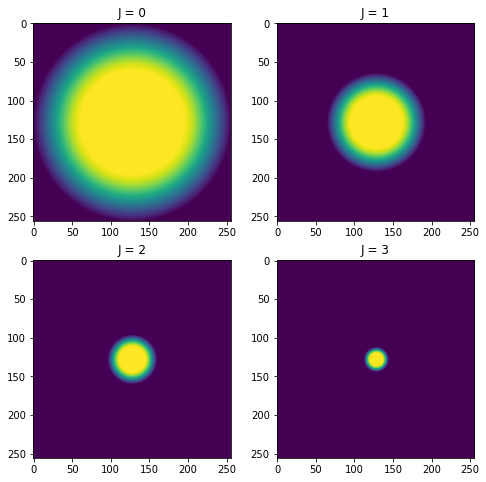

In [ ]:
plt.figure(figsize = (8,8))
c = 1
for j in range(4):
    plt.subplot(2,2,c)
    plt.title('J = {}'.format(j))
    plt.imshow(L_grid(grid,j))
    c = c+1

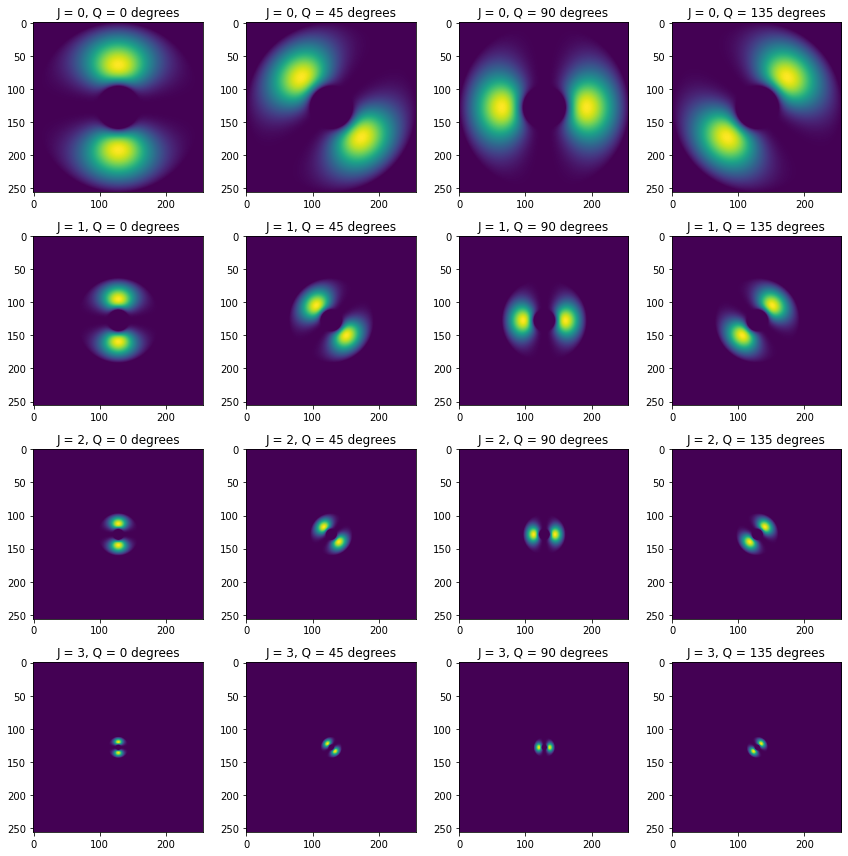

In [ ]:
plt.figure(figsize = (12,12))
c = 1
for j in range(J):
    for q in range(Q):
        plt.subplot(4, 4, c)
        plt.title('J = {}, Q = {} degrees'.format(int((c-1)/4), (c-1)%4 * 45))
        plt.imshow(psi[:,:,q,j])
        c = c+1
plt.tight_layout()

# Helper Functions for Scattering Transform

The following function compute a "wavelet pyramid", which takes the image and convolves it with each of the bandpass filters and then takes the absolute value and stores it in a list. Then, the image is convolved with a low pass filter and stored in a list. Some pseudocode is given below:

If we apply the original image to the pyramid, then the following will occur
* Start with an empty list and denote it pyramid
* Take an input image $x$, a set of scales with maximum $J$, and a set of $Q$ angles $$\left\{0,\frac{180}{Q}, \frac{2}{Q}\cdot 180, \ldots, \frac{Q-1}{Q}\cdot 180\right\}.$$ 
* For each scale $0 \leq j_1 < J$ and each angle $\frac{q}{Q} \cdot 180^\circ$, calculate $|x \ast \psi_{q,j_1}|$ and save this and the scale $j_1$ as an ordered pair and store in the list.
* Store $|x \ast \phi_J|$ in the list.

In the future steps, we'll take each $|x \ast \psi_{q,j_1}|$ or higher order coefficients and run it through the pyramid as well. The following modifcation will be made though:
* If $j_1\geq j_2$, then skip putting $|x \ast \psi_{q,j_1}|$ (or the higher order coefficient) through the pyramid.



In [ ]:
def wavelet_pyramid(img, num_scales, num_orientations, high_pass, low_pass, scale = -1, scatter = True):
    pyramid = []
    img_fft = np.fft.fft2(img)
    for j in range(num_scales):
        if(j > scale): #if scale was already used, skip over it next time
            for q in range(num_orientations):
                if(scatter == True):
                    wavelet_coeff = np.abs(np.fft.ifft2(np.fft.fftshift(high_pass[:,:,q,j]) * img_fft))
                    pyramid.append((wavelet_coeff,j))
                else:
                    wavelet_coeff = np.real(np.fft.ifft2(np.fft.fftshift(high_pass[:,:,q,j]) * img_fft))
                    pyramid.append((wavelet_coeff,j))
    pyramid.append(np.real(np.fft.ifft2(np.fft.fftshift(low_pass) * img_fft)))
    return pyramid


# Scattering Transform

Now that the wavelet pyramid is done, we can move on to the scattering transform. The steps can be described as follows using Pseudocode based on the Pseudocode given in "Invariant Scattering Convolution Networks" by Bruna and Mallat. We do the following:
* Take in $J$, the number of scales, and $Q$, the number of angles. Also, take in an image $x$ and the number of layers in the scattering transform (max depth).
* Start by Computing the Wavelet Pyramid of our image, $x$.
* The last coefficient is $x \ast \phi_J$. Append this to a list of wavelet scattering coeffciients.
* Keep the other $PQ$ components of the pyramid.
* If the max depth is $1$, convolve each of the $PQ$ coefficients with $\phi_J$.
* If the max depth is greater than $1$, then taken each of the $PQ$ wavelet coefficients and pass it through the wavelet pyramid. Remember that if $j_2 > j_1$, we skip.
* Repeat this process until the current depth reaches the max depth.
* In the last layer, just apply the low pass to each coefficient that we usually send through to the wavelet pyramid.

This picture from [Mathworks](https://ww2.mathworks.cn/help/wavelet/ug/wavelet-scattering.html) also helps:

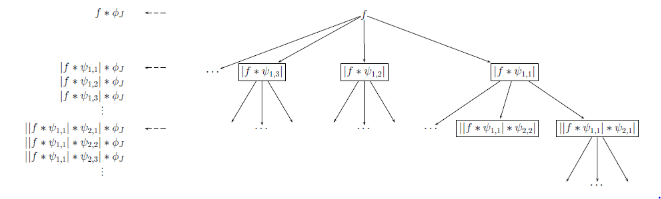




In [ ]:
#just a function to do convolution in frequency using ffts
def conv_frequency(img, filter_):
    return np.real(np.fft.ifft2(np.fft.fft2(img) * np.fft.fftshift(filter_)))

In [ ]:
def wavelet_scattering_transform(img, J, Q, depth, high_pass, low_pass, scattering = True):
    #initialize array to store all wavelet coefficients
    wavelet_coefficients = []

    for d in range(depth):
        if d == 0:
            pyramid = wavelet_pyramid(img, J, Q, high_pass, low_pass, scatter = scattering) #calculate pyramid
            wavelet_coefficients.append(np.real(pyramid[-1])) #put low pass in as wavelet coefficient
            pyramid = pyramid[:-1] #keep only necessary elements of pyramid.
        elif d == 1: 
            new_pyramid = []
            for item in pyramid:
                coeff, curr_scale = item 
                coeff_pyra = wavelet_pyramid(coeff, J, Q, high_pass, low_pass, scale = curr_scale, scatter = scattering)
                wavelet_coefficients.append(np.real(coeff_pyra[-1]))
                new_pyramid.append(np.real(coeff_pyra[:-1]))
            pyramid = new_pyramid
        else:
            new_pyramid = []
            for pyra in pyramid:
                for item in pyra:
                    coeff, curr_scale = item 
                    coeff_pyra = wavelet_pyramid(coeff, J, Q, high_pass, low_pass, scale = curr_scale, scatter = scattering)
                    wavelet_coefficients.append(np.real(coeff_pyra[-1]))
                new_pyramid.append(np.real(coeff_pyra[:-1]))
            pyramid = new_pyramid
    if(depth > 1):
        for pyra in pyramid:
            for item in pyra:
                coeff, scale = item
                wavelet_coefficients.append(conv_frequency(coeff, low_pass))
    elif(depth == 1):
        for item in pyramid:
            coeff, scale = item
            wavelet_coefficients.append(conv_frequency(coeff, low_pass))
        
    return wavelet_coefficients

# Testing on Image

Now, let's test this out on an image. We'll first just calculate the wavelet coefficients. That is, we'll calculate $x \ast \psi_{j,q}$ without the absolute values. 

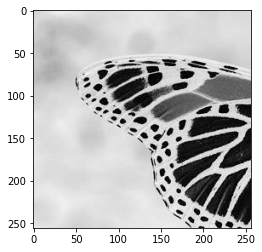

In [ ]:
# Load image and crop
img_orig = mpimg.imread('/content/drive/MyDrive/butterfly.jpg')
img = img_orig[:256, :256]
plt.imshow(img,  cmap='Greys')
plt.grid(False)

## Wavelet Coefficients

In [ ]:
depth  = 2
J = 2
Q = 3
grid = polar_grid(img.shape[0], img.shape[1])
psi = psi_grid(grid, Q, J)
phi = L_grid(grid, J)

In [ ]:
wavelet_transform = wavelet_pyramid(img, J, Q, psi, phi, scatter = False)

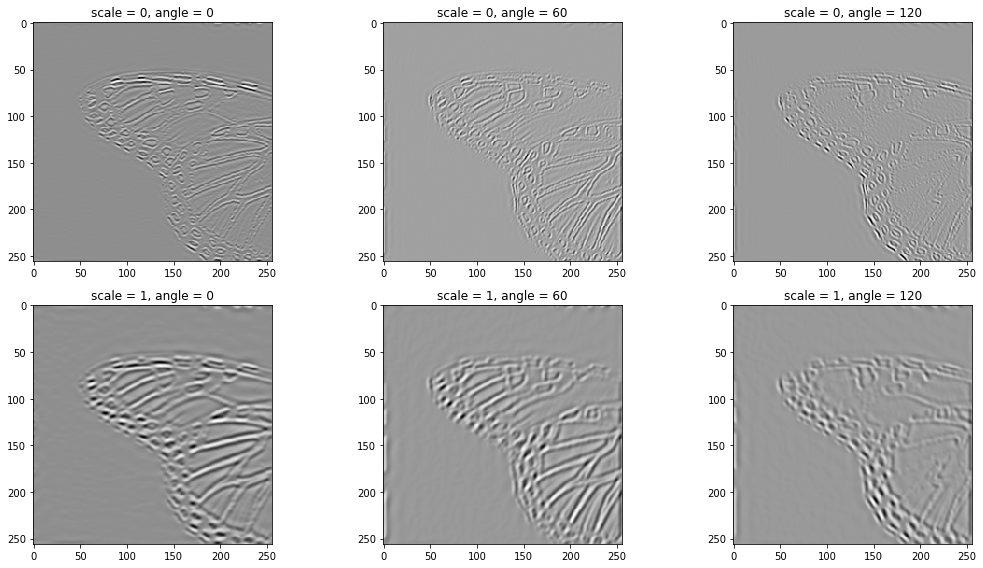

In [ ]:
c = 1
plt.figure(figsize = (15,8))
for item in wavelet_transform[:-1]:
    coeff, scale = item
    plt.subplot(J,Q,c)
    plt.imshow(coeff, cmap = 'Greys', interpolation = 'nearest')
    plt.title('scale = {}, angle = {}'.format(scale, (c-1)%Q * 60))
    plt.grid(False)
    c = c+1
plt.tight_layout()


Notice in the image above, we detected horizontal edges

## Finding Wavelet Scattering Coefficients as Sanity Check

Okay, so we had some nice edge detection above. Let's try to check the scattering coefficients too. Note that these will be pretty blurry because of the low pass filter. This is to prevent fine details from becoming a problem when we actually use the scattering coefficients for machine learning purposes.

## Checking Scattering Coefficients

In [ ]:
scattering_coeff = wavelet_scattering_transform(img, J, Q, depth, psi, phi)
scattering_coeff = np.real(scattering_coeff)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


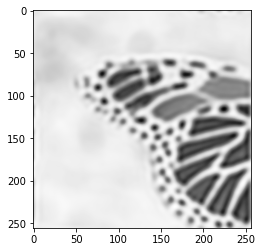

In [ ]:
plt.imshow(scattering_coeff[0], cmap = 'Greys')
plt.grid(False)

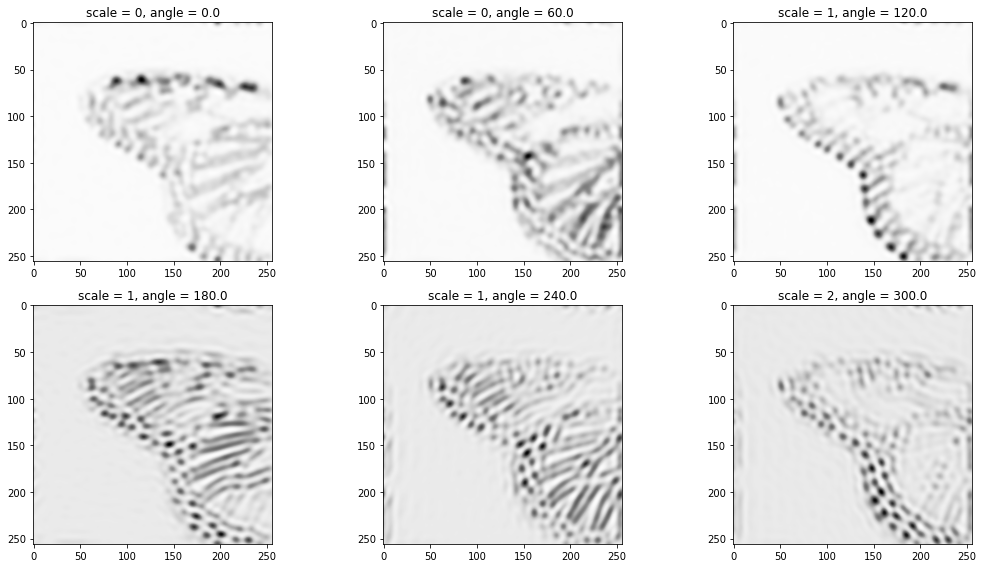

In [ ]:
c = 1
plt.figure(figsize = (15,8))
for j in range(J):
    for q in range(Q):
        plt.subplot(J,Q,c)
        plt.imshow(scattering_coeff[c], cmap = 'Greys')
        plt.title('scale = {}, angle = {}'.format(round((c-1)/3), (c-1)/Q * 180))
        plt.grid(False)
        c = c+1
plt.tight_layout()

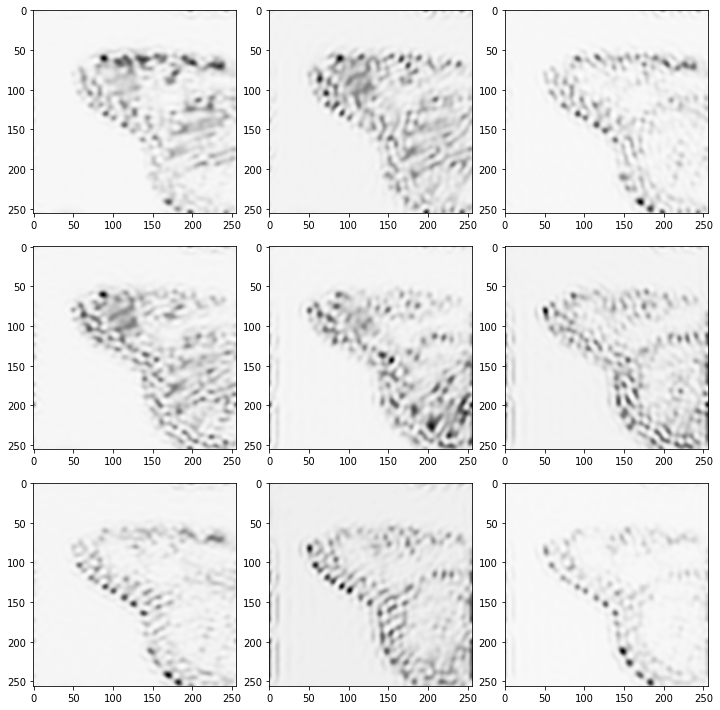

In [ ]:
c = 1
plt.figure(figsize = (10,10))
plt.title("Second Layer Coefficients")
for j in range(7, 16):
    plt.subplot(3,3,c)
    plt.imshow(scattering_coeff[j], cmap = 'Greys')
    plt.grid(False)
    c = c+1
plt.tight_layout()

#Function for Transforming Dataset

Now that we have working scattering coefficients, we'll make a function that we can feed it into for future use. This function will scatter transform all our images and then put all the scattering coefficients from one datapoint into a vector. We'll use this as our dataset.

In [ ]:
def transform_data(data, J, Q, depth, img_height, img_width, high_pass, low_pass, print_features = True):
    data = data.reshape((data.shape[0], img_height, img_width))
    transform_init_sample = np.real(wavelet_scattering_transform(data[0,:,:].reshape((img_height,img_width)), J, Q, depth, high_pass, low_pass))
    num_features = len(transform_init_sample) *img_width * img_height
    transform = np.zeros((data.shape[0], num_features), dtype = np.float16)
    features = transform_init_sample[0]
    for n in range(1,len(transform_init_sample)):
        features = np.concatenate((features, transform_init_sample[n]), axis= None)
    transform[0,:] = features
    
    for n in range(1,data.shape[0]):
        sample = data[n,:,:].reshape((img_height,img_width))
        trans_sample = np.real(wavelet_scattering_transform(sample, J, Q, depth, high_pass, low_pass))
        features = trans_sample[0]
        for k in range(1,len(trans_sample)):
            features = np.concatenate((features, trans_sample[k]), axis= None)
        
        transform[n,:] = features
    if(print_features == True):
        return transform, num_features
    else:
        return transform

# Finding Scattering Coefficients for Fashion MNIST

Now, let's apply this to toy dataset. Since this is a simple computer vision problem, we'll try Fashion MNIST, which is a better benchmark than normal MNIST. Our goal is to beat other MLP's and simple CNN's. It's not likely that we'll be able to beat networks like AlexNet or VGG since both networks learn in intermediate layers. This might be a good low cost alternative though (except for the high memory usage).

We've tried a few different scattering coefficent combinations with a larger network, like $J = 2$ and $\text{depth} = 2$. However, we noticed that this didn't really work well. It's probably because the images in this dataset are small and don't really contain many fine details. The angular dependencies are very important here though.

In [ ]:
# Transform data to PIL images
transforms = tfs.Compose([tfs.ToTensor(),tfs.Normalize((0.5,), (0.5,))])

# Download/Load Dataset
train_dataset = FashionMNIST('./data', train=True, transform=transforms, download=True)
test_dataset = FashionMNIST('./data', train=False, transform=tfs.Compose([tfs.ToTensor(),tfs.Normalize((0.5,), (0.5,))]), download=True)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

train_feat = next(iter(train_loader))[0].numpy()
train_feat.reshape((len(train_feat),28,28))

test_feat = next(iter(test_loader))[0].numpy()
test_feat.reshape((len(test_feat),28,28))

train_labels = next(iter(train_loader))[1]
test_labels = next(iter(test_loader))[1]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# About the Dataset

There are 10 labels (types of clothes), and here are the values of the labels. The table below was taken from the [here.](https://github.com/zalandoresearch/fashion-mnist)

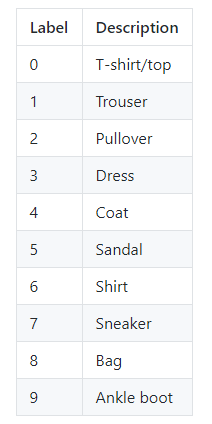

Here is an example of what some of the images might look like in this dataset.

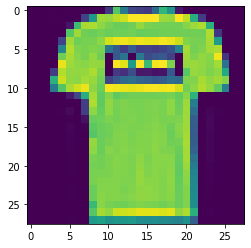

In [ ]:
plt.imshow(train_feat[1,:,:].reshape((28,28)))

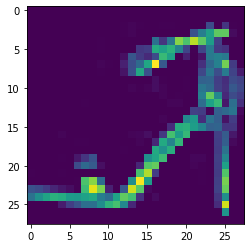

In [ ]:
plt.imshow(train_feat[8,:,:].reshape((28,28)))

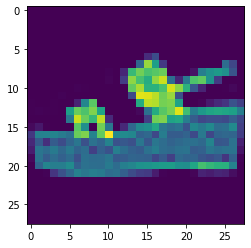

In [ ]:
plt.imshow(train_feat[12,:,:].reshape((28,28)))

It's now time to try making some scattering coefficients. We'll also print some of the scattering coefficients as examples:

In [ ]:
depth = 1
J = 1
Q = 6
grid = polar_grid(28, 28)
psi = psi_grid(grid, Q, J)
phi = L_grid(grid, J)


In [ ]:
train_transform = transform_data(train_feat, J, Q, depth, 28,28, psi,phi, print_features = False)
test_transform, num_features = transform_data(test_feat, J, Q, depth, 28,28, psi,phi)

Here are what the scattering coefficients might look like. Note that some random horizontal flips and random vertical flips have been applied to our dataset to prevent overfitting.

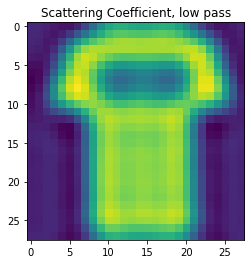

In [ ]:
%matplotlib inline
scattering_coefficient = train_transform[1,:]
plt.title('Scattering Coefficient, low pass')
coeff = np.float32(scattering_coefficient[:784].reshape((28,28))) 
plt.imshow(coeff)  

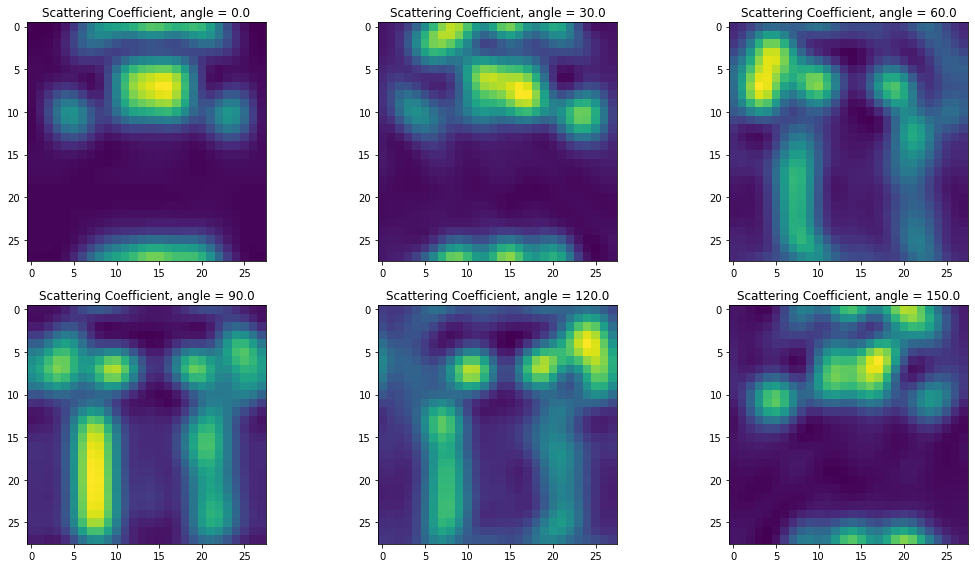

In [ ]:
plt.figure(figsize = (15,8))
for q in range(1,Q+1):
    plt.subplot(2,int(Q/2),q)
    plt.title('Scattering Coefficient, angle = {}'.format((q-1)/Q*180))
    coeff = np.float32(scattering_coefficient[784*q:784*(q+1)].reshape((28,28)))
    plt.imshow(coeff)
plt.tight_layout()

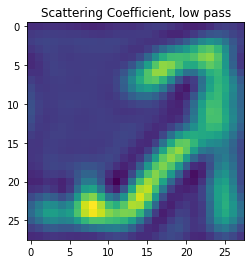

In [ ]:
scattering_coefficient = train_transform[8,:]
plt.title('Scattering Coefficient, low pass')
coeff = np.float32(scattering_coefficient[:784].reshape((28,28))) 
plt.imshow(coeff) 

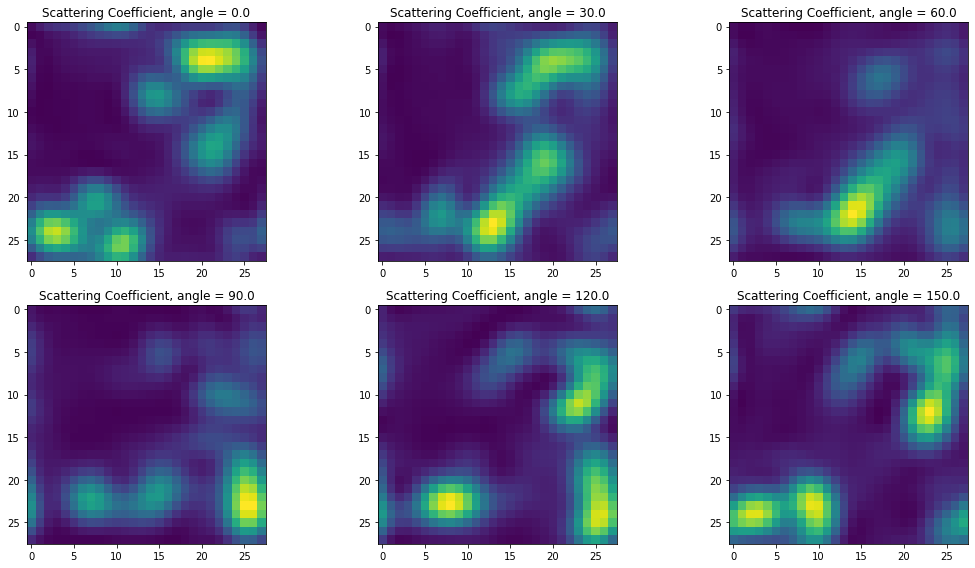

In [ ]:
plt.figure(figsize = (15,8))
for q in range(1,Q+1):
    plt.subplot(2,int(Q/2),q)
    plt.title('Scattering Coefficient, angle = {}'.format((q-1)/Q*180))
    coeff = np.float32(scattering_coefficient[784*q:784*(q+1)].reshape((28,28)))
    plt.imshow(coeff)
plt.tight_layout()

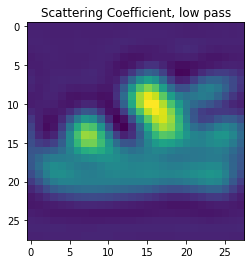

In [ ]:
scattering_coefficient = train_transform[12,:]
plt.title('Scattering Coefficient, low pass')
coeff = np.float32(scattering_coefficient[:784].reshape((28,28))) 
plt.imshow(coeff)  

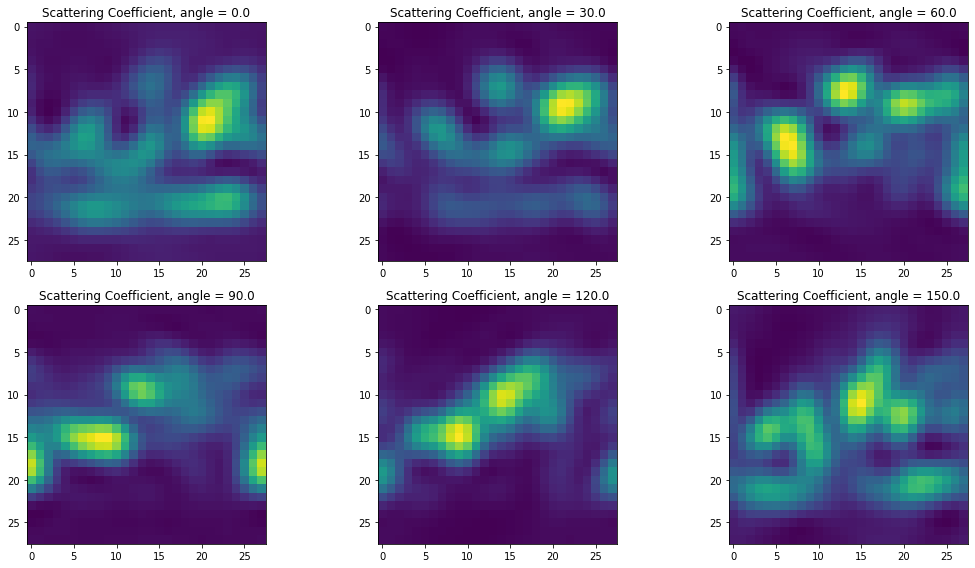

In [ ]:
plt.figure(figsize = (15,8))
for q in range(1,Q+1):
    plt.subplot(2,int(Q/2),q)
    plt.title('Scattering Coefficient, angle = {}'.format((q-1)/Q*180))
    coeff = np.float32(scattering_coefficient[784*q:784*(q+1)].reshape((28,28)))
    plt.imshow(coeff)
plt.tight_layout()

Let's make our data into tensors and check the number of features:

In [ ]:
train_transform = torch.Tensor(train_transform)
test_transform = torch.Tensor(test_transform)


In [ ]:
print(num_features)

5488


## Save Model if Needed

In [ ]:
torch.save(torch.Tensor(train_transform), '/content/drive/MyDrive/FashionMNIST_Transform/train_data_fashion_mnist.pt')
torch.save(torch.Tensor(test_transform), '/content/drive/MyDrive/FashionMNIST_Transform/test_data_fashion_mnist.pt')

In [ ]:
train_transform = torch.load('/content/drive/MyDrive/FashionMNIST_Transform/train_data_fashion_mnist.pt')
test_transform = torch.load('/content/drive/MyDrive/FashionMNIST_Transform/test_data_fashion_mnist.pt')

# Training Model using PyTorch

In [ ]:
train = TensorDataset(train_transform, train_labels)
test = TensorDataset(test_transform, test_labels)

In [ ]:
# Data Loaders
train_mask = range(50000)
val_mask = range(50000, 60000)
train_load = DataLoader(train, batch_size=256, sampler=SubsetRandomSampler(train_mask))
val_load = DataLoader(train, batch_size=100, sampler=SubsetRandomSampler(val_mask))
test_load = DataLoader(test, batch_size=100)

In [ ]:
class ANN(nn.Module):
    def __init__(self, nin, nout):
        super(ANN, self).__init__()
        self.Linear1 = nn.Linear(nin,512)
        self.bn1 = nn.BatchNorm1d(512)
        self.Linear2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.Linear3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.Linear4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.Linear5 = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.Linear1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(self.Linear2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(self.Linear3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = F.relu(self.Linear4(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.Linear5(x)
        return F.softmax(x, dim = -1)
    

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform(m.weight.data)

In [ ]:
def evaluate(dataloader, model, gpu = True, name = 'Train'):
    correct = 0
    total = 0
    model.eval()
    for data, labels in dataloader:
        if gpu == True:
            data = data.cuda()
            labels = labels.cuda()
        outputs = model(data)
        predicted = torch.argmax(outputs.data,-1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()  
    print('{} accuracy: {}'.format(name,(100.0 * correct / total)))
    return
    

In [ ]:
scatterNet = ANN(num_features, 10)
weights_init(scatterNet)
use_gpu = True
if(use_gpu == True):
    scatterNet = scatterNet.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(scatterNet.parameters(), lr = 8e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

for epoch in range(50):
    scatterNet.train()
    for i, (features, labels) in enumerate(train_load):
        optimizer.zero_grad() 
        if use_gpu == True:
            features = features.cuda()
            labels = labels.cuda()
        output = scatterNet(features)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if ((epoch+1)%10 == 0):
        print('Epoch {}:'.format(epoch+1))
        evaluate(train_load, scatterNet, use_gpu, 'Train')
        evaluate(val_load, scatterNet, use_gpu, 'Val')
        evaluate(test_load, scatterNet, use_gpu, 'Test')

#save model for later use
torch.save(scatterNet, '/content/drive/MyDrive/FashionMNIST_Transform/model.pth')
    

Epoch 10:
Train accuracy: 91.0199966430664
Val accuracy: 89.5
Test accuracy: 89.6199951171875
Epoch 20:
Train accuracy: 92.35599517822266
Val accuracy: 90.83999633789062
Test accuracy: 90.30999755859375
Epoch 30:
Train accuracy: 93.08599853515625
Val accuracy: 90.93000030517578
Test accuracy: 90.70999908447266
Epoch 40:
Train accuracy: 93.75999450683594
Val accuracy: 91.07999420166016
Test accuracy: 91.04000091552734
Epoch 50:
Train accuracy: 93.99800109863281
Val accuracy: 91.25999450683594
Test accuracy: 91.47999572753906


It looks like the accuracy at the end of training on the test set was: 91.5%.

# Benchmarks

Here are some comparisons that I found online at [Zalando Research.](https://github.com/zalandoresearch/fashion-mnist) These are the interesting ones:
* A 256-128-64-32-10 MLP got 88.4% accuracy in 100 training iterations.
* Two or three layer ConvNets usually get 91-93% accuracy, but they are actually much better suited for this task. This algorithm is good at extracting details, which this dataset doesn't really have. There's also no intermediate learning in my model, which is very necessary for high accuracy. 
*Our feature extraction with the scattering transform took approximately 2 minutes on this dataset, which isn't long. The training of our network took approximately 5 minutes, which beats most CNNS that take almost triple the time.
* GRU's apparently do OK on this task and get about 89% accuracy.

From these results, it seems like our scattering network does well, and it even can beat some simple ConvNets (it beat LeNet at least). However, it's not state of the art since networks like ResNet or GoogleNet can get much higher accuracy.


# Further Work/Conclusions

From the images of the scattering transforms, this method doesn't really suit the task we're working on since my images don't have any features other than relative pixel intensities. This implies the Scattering Transform isn't a very viable approach. 

Right now, my algorithm has no way of downsampling. If we add downsampling, we can decrease image sizes and also scale my model to be more managable since the parameter count is high.